In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("air_quality.csv")
df.head()

,hum,mq,ts,temp
0,59,226,1261,21
1,59,227,1267,21
2,59,238,1272,21
3,59,240,1277,21
4,59,233,1283,21


In [3]:
df.describe()

,hum,mq,ts,temp
count,1477.000000,1477.000000,1477.000000,1477.000000
mean,60.194313,224.689912,5153.457684,20.874069
std,1.435901,27.890684,2249.353170,0.331884
min,58.000000,149.000000,1261.000000,20.000000
25%,59.000000,209.000000,3207.000000,21.000000
50%,60.000000,227.000000,5153.000000,21.000000
75%,61.000000,241.000000,7099.000000,21.000000
max,64.000000,308.000000,9046.000000,21.000000


In [4]:
df["ts"] = pd.to_numeric(df["ts"])

In [5]:
%pip install matplotlib


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


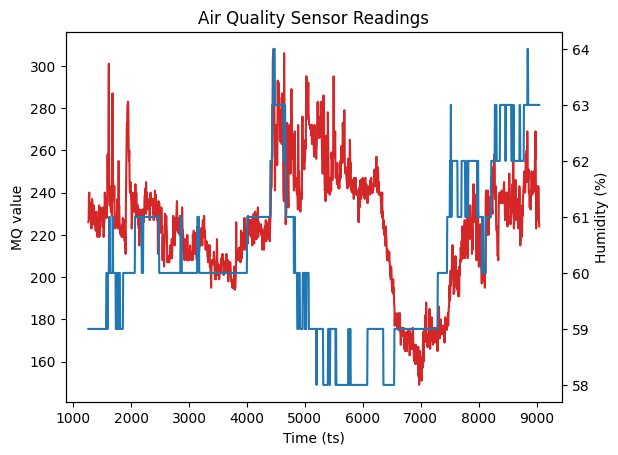

In [6]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.plot(df["ts"], df["mq"], label="MQ", color="tab:red")
ax1.set_ylabel("MQ value")

ax2 = ax1.twinx()
ax2.plot(df["ts"], df["hum"], label="Humidity", color="tab:blue")
ax2.set_ylabel("Humidity (%)")

ax1.set_xlabel("Time (ts)")
plt.title("Air Quality Sensor Readings")
plt.show()

In [7]:
cols = ["mq", "temp", "hum", "ts"]
df[cols] = df[cols].apply(pd.to_numeric)

In [8]:
# ---- Feature Engineering ----

# 1. Normalized gas value (stable)
df["gas_norm"] = df["mq"] / (df["temp"] * df["hum"] + 1)

# 2. Rolling statistics (last 10 samples)
WINDOW = 10
df["rolling_mean_10"] = df["mq"].rolling(WINDOW).mean()
df["rolling_std_10"]  = df["mq"].rolling(WINDOW).std()

# 3. Rate of change / derivative
df["gas_diff"] = df["mq"].diff()
df["gas_diff_norm"] = df["gas_diff"] / (df["mq"].shift(1) + 1e-5)

# 4. Humidity adjusted index
df["hum_adjusted_gas"] = df["mq"] * (1 + df["hum"] / 100)

# 5. Interaction features
df["temp_hum"] = df["temp"] * df["hum"]
df["temp_gas"] = df["temp"] * df["mq"]
df["hum_gas"]  = df["hum"] * df["mq"]

In [9]:
df = df.dropna().reset_index(drop=True)

In [10]:
df.to_csv("air_quality_features.csv", index=False)


In [11]:
print(df.head())

   hum   mq    ts  temp  gas_norm  rolling_mean_10  rolling_std_10  gas_diff  \
0   59  225  1309    21  0.181452            231.3        5.271517      -8.0   
1   59  223  1314    21  0.179839            231.0        5.676462      -2.0   
2   59  224  1319    21  0.180645            230.7        5.982382       1.0   
3   59  237  1325    21  0.191129            230.6        5.853774      13.0   
4   59  236  1330    21  0.190323            230.2        5.245104      -1.0   

   gas_diff_norm  hum_adjusted_gas  temp_hum  temp_gas  hum_gas  
0      -0.034335            357.75      1239      4725    13275  
1      -0.008889            354.57      1239      4683    13157  
2       0.004484            356.16      1239      4704    13216  
3       0.058036            376.83      1239      4977    13983  
4      -0.004219            375.24      1239      4956    13924  


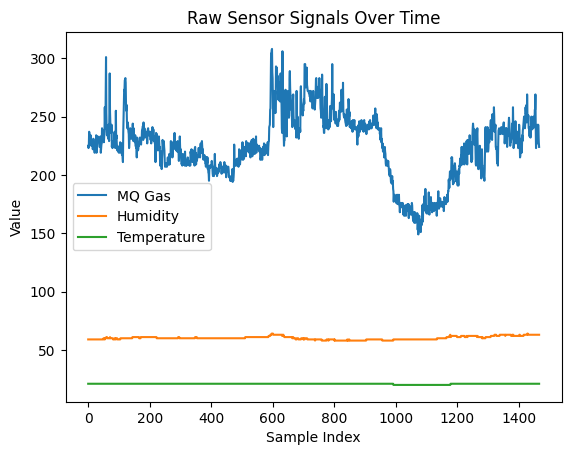

In [12]:
plt.figure()
plt.plot(df.index, df["mq"])
plt.plot(df.index, df["hum"])
plt.plot(df.index, df["temp"])
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Raw Sensor Signals Over Time")
plt.legend(["MQ Gas", "Humidity", "Temperature"])
plt.show()

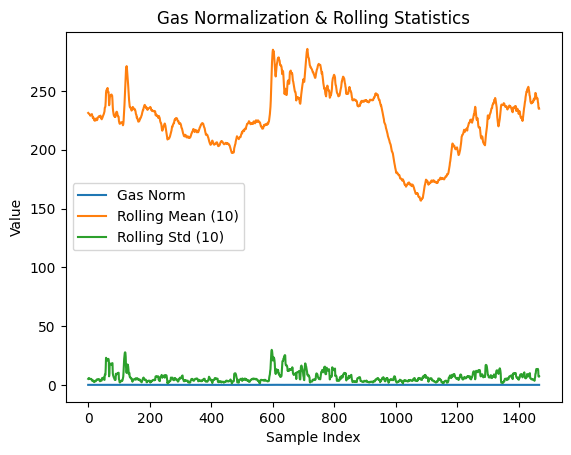

In [13]:
plt.figure()
plt.plot(df.index, df["gas_norm"])
plt.plot(df.index, df["rolling_mean_10"])
plt.plot(df.index, df["rolling_std_10"])
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Gas Normalization & Rolling Statistics")
plt.legend(["Gas Norm", "Rolling Mean (10)", "Rolling Std (10)"])
plt.show()

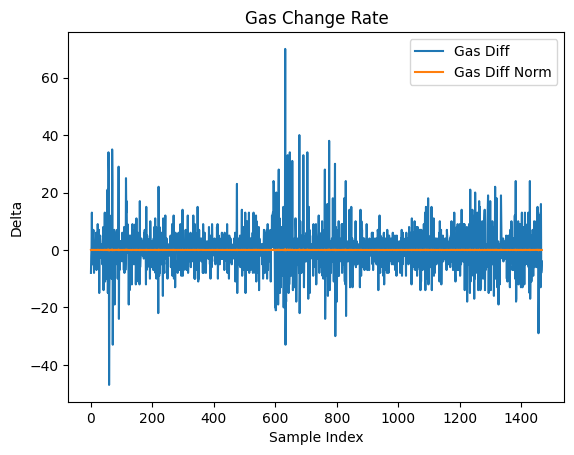

In [14]:
plt.figure()
plt.plot(df.index, df["gas_diff"])
plt.plot(df.index, df["gas_diff_norm"])
plt.xlabel("Sample Index")
plt.ylabel("Delta")
plt.title("Gas Change Rate")
plt.legend(["Gas Diff", "Gas Diff Norm"])
plt.show()

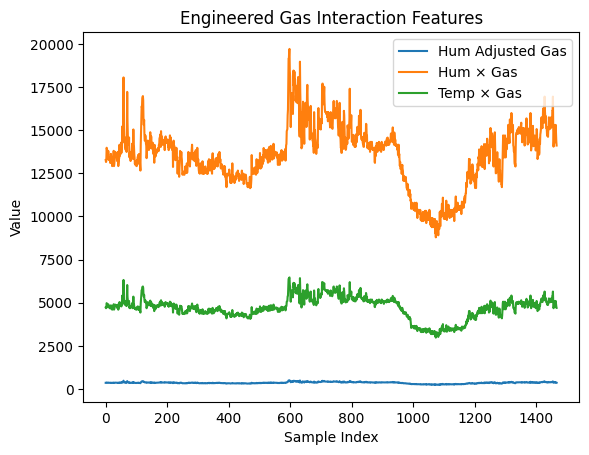

In [15]:
plt.figure()
plt.plot(df.index, df["hum_adjusted_gas"])
plt.plot(df.index, df["hum_gas"])
plt.plot(df.index, df["temp_gas"])
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Engineered Gas Interaction Features")
plt.legend(["Hum Adjusted Gas", "Hum × Gas", "Temp × Gas"])
plt.show()


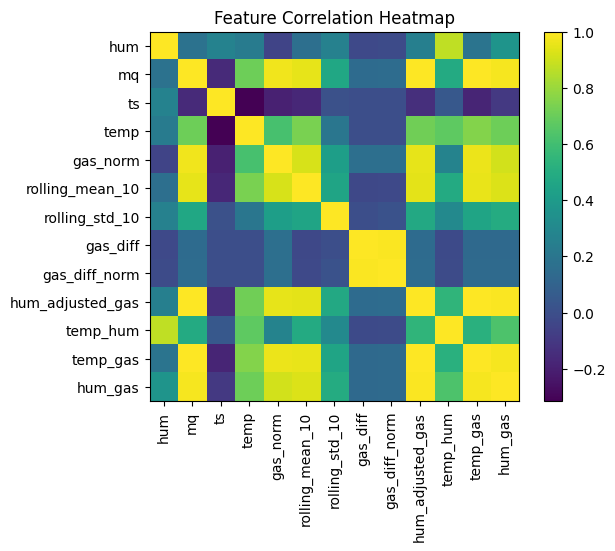

In [16]:
plt.figure()
corr = df.corr()
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Feature Correlation Heatmap")
plt.show()

In [17]:
df.columns

Index(['hum', 'mq', 'ts', 'temp', 'gas_norm', 'rolling_mean_10',
       'rolling_std_10', 'gas_diff', 'gas_diff_norm', 'hum_adjusted_gas',
       'temp_hum', 'temp_gas', 'hum_gas'],
      dtype='object')

In [18]:
FEATURES = [
    "gas_norm",
    "rolling_mean_10",
    "rolling_std_10",
    "gas_diff",
    "gas_diff_norm",
    "hum_adjusted_gas",
    "temp_hum",
    "temp_gas",
    "hum_gas"
]

In [19]:
DATA_PATH = "air_quality_features.csv"
MODEL_DIR = "models"

df = pd.read_csv(DATA_PATH)
X = df[FEATURES]

In [20]:
%pip install joblib
%pip install scikit-learn


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
import numpy as np
import joblib
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [22]:
print("\n🔹 Training Anomaly Detection Model...")

anomaly_model = IsolationForest(
    n_estimators=300,
    contamination=0.01,
    random_state=42
)

anomaly_model.fit(X)


🔹 Training Anomaly Detection Model...


,"n_estimators n_estimators: int, default=100The number of base estimators in the ensemble.",300
,"max_samples max_samples: ""auto"", int or float, default=""auto""The number of samples to draw from X to train each base estimator.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` samples.- If ""auto"", then `max_samples=min(256, n_samples)`.If max_samples is larger than the number of samples provided,all samples will be used for all trees (no sampling).",'auto'
,"contamination contamination: 'auto' or float, default='auto'The amount of contamination of the data set, i.e. the proportionof outliers in the data set. Used when fitting to define the thresholdon the scores of the samples.- If 'auto', the threshold is determined as in the original paper.- If float, the contamination should be in the range (0, 0.5]... versionchanged:: 0.22 The default value of ``contamination`` changed from 0.1 to ``'auto'``.",0.01
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator.- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.Note: using a float number less than 1.0 or integer less than number offeatures will enable feature subsampling and leads to a longer runtime.",1.0
,"bootstrap bootstrap: bool, default=FalseIf True, individual trees are fit on random subsets of the trainingdata sampled with replacement. If False, sampling without replacementis performed.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for :meth:`fit`. ``None`` means 1unless in a :obj:`joblib.parallel_backend` context. ``-1`` means usingall processors. See :term:`Glossary ` for more details.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo-randomness of the selection of the featureand split values for each branching step and each tree in the forest.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity of the tree building process.",0
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fit a wholenew forest. See :term:`the Glossary `... versionadded:: 0.21",False


In [23]:
joblib.dump(anomaly_model, f"{MODEL_DIR}/anomaly_model.joblib")

['models/anomaly_model.joblib']

In [24]:
import pandas as pd
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# -------------------------
# Config
# -------------------------
DATA_PATH = "air_quality_features.csv"
MODEL_DIR = "models"

FEATURES = [
    "gas_norm",
    "rolling_mean_10",
    "rolling_std_10",
    "gas_diff",
    "gas_diff_norm",
    "hum_adjusted_gas",
    "temp_hum",
    "temp_gas",
    "hum_gas"
]

# -------------------------
# Load data
# -------------------------
df = pd.read_csv(DATA_PATH)
X = df[FEATURES]

# -------------------------
# Heuristic labels
# -------------------------
def air_quality_label(mq):
    if mq < 220:
        return 0  # Good
    elif mq < 260:
        return 1  # Moderate
    elif mq < 300:
        return 2  # Poor
    else:
        return 3  # Hazardous

df["aq_label"] = df["mq"].apply(air_quality_label)
y = df["aq_label"]

# -------------------------
# Train / Validation split
# -------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# -------------------------
# Train Decision Tree
# -------------------------
print("🔹 Training AQ classifier (Decision Tree)...")

model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=30,
    random_state=42
)

model.fit(X_train, y_train)

# -------------------------
# Evaluation
# -------------------------
y_pred = model.predict(X_val)

print("\n📊 Classification Report:")
print(classification_report(y_val, y_pred))

print("\n📉 Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# -------------------------
# Save artifacts
# -------------------------
joblib.dump(model, f"{MODEL_DIR}/aq_classifier_tree.joblib")
joblib.dump(FEATURES, f"{MODEL_DIR}/features.joblib")

print("\n✅ Decision Tree AQ classifier saved")
print("🎉 Training complete")

🔹 Training AQ classifier (Decision Tree)...

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00       156
           2       0.96      1.00      0.98        27
           3       0.00      0.00      0.00         1

    accuracy                           1.00       294
   macro avg       0.74      0.75      0.75       294
weighted avg       0.99      1.00      0.99       294


📉 Confusion Matrix:
[[110   0   0   0]
 [  0 156   0   0]
 [  0   0  27   0]
 [  0   0   1   0]]

✅ Decision Tree AQ classifier saved
🎉 Training complete


/home/nasim/Code/micropython/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/nasim/Code/micropython/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/nasim/Code/micropython/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi